In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import matplotlib 

In [2]:
def BS_call_price_delta(sigma, S, K, r, T, t, Greek):
    
    if Greek == 'Price' and T > 0: # Pris for en call option
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        d2 = d1 - sigma * np.sqrt((T-t))
        result = np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2) * K, np.exp(-r * (T-t)))
        
    if Greek == 'Price' and T == 0:
        result = max(S-K,0)
    
    if Greek == "Delta" and T > 0: # dC/dS = Delta - Hvor meget vi skal købe/sælge af det underliggende aktiv
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        result = norm.cdf(d1)
        
    
    if Greek == 'Delta' and T == 0:
        result = 0
    
    return result

Note: For ændring af antallet af gange man hedger juster under parameteren Nhedgepoints

In [3]:
### Parameter ###
S_0 = 100
T = 1
t = 0 
K = 110
r = 0.002
mu = 0.1   
# Trend/drift i markedet. 
# Lav mu -> kursen konvergere mod sit naturlige niveau (nuværende værdi) = mean reversion, eks. råstoffer.
# Høj mu -> kursen bevæger sig mod en nyt niveau, følger enten høj/positiv eller lav/negativ trend/udvikling.
sigma = 0.2 # volatilitet
Nhedgepoints = 12 # Antal gange man hedger (Ændrer i sin portefølje)
Npaths = 10000 # Antal simuleringer

dt = (T-t)/Nhedgepoints 

In [4]:
# Results
S_t = [0.0] * Npaths
Option_Payoff = [0.0] * Npaths
Hedge_Payoff = [0.0] * Npaths
Error = [0.0] * Npaths

np.random.seed(12345)

In [5]:
### Simulation Engine ###
# Loop over Npaths
for j in range(0, Npaths):
    S = S_0
   
    # DeltaHedge
    V = BS_call_price_delta(sigma, S, K, r, T, t, "Price") # Start investering i call-option: Pris på call-option
    a = BS_call_price_delta(sigma, S, K, r, T, t, "Delta") # Investering i underliggende aktiv <- delta
    b = V-a*S # Resten af sine penge i banken, self-fin. Cond. 
    # Loop over Nhedgepoints
    for i in range(0, Nhedgepoints+1):
        eps = np.random.normal(0, 1) # Normeps=random.normal() simulate outcome of N(0,1)
        S = S*np.exp((mu-sigma**2/2)*dt+sigma*np.sqrt(dt)*eps)
        # Delta-Hedge
        V = a*S+b*np.exp(r*dt) # Værdien af ens portefølje på nuværende tidspunkt: underliggende aktiv + penge i banken
        a = BS_call_price_delta(sigma, S, K, r, T-i*dt, t, "Delta") # Finder delta for det nuværende tidspunkt
        b = V-a*S # Hvor mange penge vi har i banken til nuværende tidspunkt
   
    S_t[j] = S # Samler alle aktiekurser til udløb
    Hedge_Payoff[j] = V # Samler alle værdier af porteføljer til udløb
    Option_Payoff[j] = BS_call_price_delta(sigma, S, K, r, 0, 0, "Price") # Samler payoff på alle call option

# Calc Error
Error = np.array(Hedge_Payoff) - np.array(Option_Payoff)




In [6]:
np.std(Error)

2.133796614191394

In [7]:
np.std(Error)/BS_call_price_delta(sigma, S, K, r, T, t, "Price")

0.05480460660817638

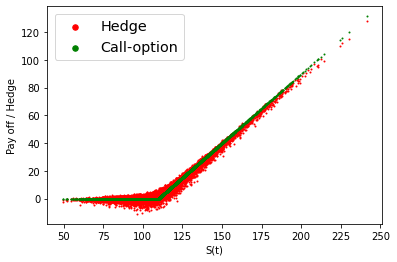

In [8]:
# Plot
import matplotlib.pyplot as plt
plt.scatter(S_t, Hedge_Payoff, s=1, color='red', label='Hedge')
plt.scatter(S_t, Option_Payoff, s=1, color='green', label='Call-option')
lgnd = plt.legend(loc='upper left', fontsize = 'x-large')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.xlabel('S(t)')
plt.ylabel('Pay off / Hedge')
plt.show()

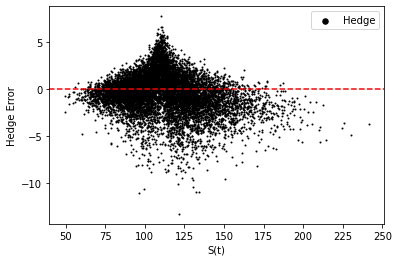

In [9]:
# Plot
import matplotlib.pyplot as plt
plt.scatter(S_t, Error, color='black', s=1, label='Hedge')
lgnd = plt.legend(loc='upper right', fontsize = 'medium')
lgnd.legendHandles[0]._sizes = [30]
plt.xlabel('S(t)')
plt.ylabel('Hedge Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()